In [1]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import backend as K
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
# Define our classes
class NeuralNetworkFactory:
    def __init__(self):
        pass
    def build_sequential_model(self, nodes, activations, input_size):
        model = Sequential()
        # First layer is the input layer
        model.add(Dense(nodes[0], input_dim=input_size, activation=activations[0]))
        # After the first, read all nodes and activations given to build the DFF model
        for i in range(1, len(nodes)):
            model.add(Dense(nodes[i], activation=activations[i]))
        return model
    
class CategoricalEnsemble:
    def __init__(self, ensemble_size, num_labels, input_shape, losses, optimizers, metrics, learning_rates, voting_method='sum'):
        # Number of models in the ensemble
        self.ensemble_size = ensemble_size
        # How voting will be conducted. "sum" or "count"
        self.voting_method = voting_method
        # The ensemble's factory for producing models
        self.factory = NeuralNetworkFactory()
        # Build models with proper hyperparameters
        self.create_models(num_labels, input_shape, losses, optimizers, metrics, learning_rates)
    def create_models(self, num_labels, input_size, losses, optimizers, metrics, learning_rates):
        self.models = []
        for i in range(self.ensemble_size):
            # To keep things interesting, define each DFF model as a random depth! This could be subbed in as a given list just like other hyperparameters
            numNeurons = random.randint(3, 10)
            # Build up from 8 nodes -> 2**1/2 numNeurons, then back down
            nodes = [2**(n + 3) if (n <= (numNeurons / 2)) else 2**(numNeurons - n + 3) for n in range(numNeurons)]
            # Final node should be ready for a softmax of all possible labels
            nodes[-1] = num_labels
            # Hardcode in RELU for simplicity
            activations = ['relu' for n in range(numNeurons)]
            # Final layer should be a softmax for categorical classification
            activations[-1] = 'softmax'
            # Compile and add to the list
            self.models.append(
                self.compile_model(
                    self.factory.build_sequential_model(nodes, activations, input_size), 
                losses[i], optimizers[i], metrics[i], learning_rates[i])
            )
    def compile_model(self, model, loss, optimizer, metrics, learning_rate):
        # Wrapper function for model compilation. Also allows manual setting of learning rate while keeping the string optimizer selection
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        K.set_value(model.optimizer.learning_rate, learning_rate)
        return model
    def fit_models(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        # Keep history of each model's fit for future use...
        self.histories = []
        # Count and print to keep track of where we are!
        count = 0
        for model in self.models:
            print("Training Model #", count)
            count += 1
            history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))
            self.histories.append(history)
        return
    def show_models(self):
        # Wrapper for model.summary() function for some mild convenience now, and potential to display other information later
        for model in self.models:
            print(model.summary())
        return
    def evaluate_models(self, X_test, Y_test):
        # Wrapper for model.evaluate() for some mild convenience now, and potential to display more information later
        # Hold onto accuracies to view later
        self.accuracies = []
        for model in self.models:
            _, accuracy = model.evaluate(X_test, Y_test)
            self.accuracies.append(accuracy)
        return
    def poll_models(self, X_test, X_val):
        # Poll the ensemble to select the best option.
        # Begin by stacking each model's predictions onto each other, making a 3D array (n_elements x n_models x n_classes)
        # For mild convenience, also calculate the same results for validation set
        polled_results = None
        val_results = None
        # Simple way to track the first iteration. Not used after that, but doesn't take too many resources or time
        count = 0
        for model in self.models:
            y_pred = model.predict(X_test)
            y_val_pred = model.predict(X_val)
            if count == 0:
                polled_results = y_pred
                val_results = y_val_pred
                count += 1
            else:
                polled_results = np.dstack((polled_results, y_pred))
                val_results = np.dstack((val_results, y_val_pred))
        # Sum method: add up all prediction probabilities from each model, and then select the largest
        if self.voting_method == 'sum':
            votes = np.sum(polled_results, axis=2)
            self.predictions = np.argmax(votes, 1)
            votes = np.sum(val_results, axis=2)
            self.val_predictions = np.argmax(votes, 1)
        # Count method: determine the largest probability for each model, and then sum up the total
        # In a tie, the lowest class number is selected (a product of scipy.stats.mode())
        elif self.voting_method == 'count':
            votes = np.argmax(polled_results, axis=1)
            self.predictions = stats.mode(votes, axis=1)[0].T[0]
            votes = np.argmax(val_results, axis=1)
            self.val_predictions = stats.mode(votes, axis=1)[0].T[0]
        return

In [3]:
# Read in the data files
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,X000,X001,X002,X003,X004,X005,X006,X007,X008,X009,...,X384,X385,X386,X387,X388,X389,X390,X391,X392,Y
0,0.435294,0.568627,0.470588,0.239216,0.062745,0.003922,0.000000,0.000000,0.133333,0.321569,...,0.694118,0.000000,0.000000,0.000000,0.000000,0.000000,0.054902,0.243137,0.537255,5
1,0.290196,0.192157,0.098039,0.039216,0.011765,0.000000,0.000000,0.000000,0.482353,0.627451,...,0.278431,0.007843,0.019608,0.035294,0.054902,0.082353,0.133333,0.141176,0.098039,0
2,0.000000,0.000000,0.000000,0.000000,0.003922,0.027451,0.082353,0.184314,0.000000,0.000000,...,0.380392,0.007843,0.050980,0.164706,0.301961,0.400000,0.443137,0.415686,0.360784,4
3,0.745098,0.952941,0.870588,0.329412,0.035294,0.000000,0.000000,0.000000,0.000000,0.058824,...,0.000000,0.015686,0.211765,0.341176,0.800000,0.101961,0.000000,0.000000,0.000000,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9


In [4]:
# Adjust data to match the format we want for categorical classification
X = train.drop('Y', axis=1).values
X = X / X.max(axis=0)
Y = train['Y'].values
Y = to_categorical(Y)
X_test = test.drop('Y', axis=1).values
X_test = X_test / X.max(axis=0)
Y_truth = test['Y'].values
Y_test = to_categorical(Y_truth)

In [5]:
# Split train/val data -- validation size 20%
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [6]:
# Set parameters for our models
# Number of networks in our ensemble
ensemble_size = 5
# Number of possible labels in the set
num_labels = len(train['Y'].unique())
# Shape of the input. Really just 1D length of the input vector
input_shape = train.shape[1] - 1 # -1 because train.shape includes Y column
# Array of losses; each entry is for a different network. Currently set
#  as the same for each, but this can be modified depending on the problem
losses = ['categorical_crossentropy' for i in range(ensemble_size)]
# Array of optimizers; each entry is for a different network. Currently set
#  as the same for each, but this can be modified to test different ones
optimizers = ['adam' for i in range(ensemble_size)]
# Array of metrics reporting. Can be set so different networks report 
#  different metrics
metrics = [['accuracy'] for i in range(ensemble_size)]
# Array of learning rates. Currently set so each network has a slower 
#  learning rate
learning_rates = [10**(-1 * i) for i in range(ensemble_size)]

In [7]:
# Create the ensemble and confirm the desired number of models were created
ensemble = CategoricalEnsemble(ensemble_size, num_labels, input_shape, losses, optimizers, metrics, learning_rates, 'count')
len(ensemble.models)

5

In [8]:
# Fit the models in the ensemble!
epochs = 150
batch_size = 10
ensemble.fit_models(X_train, Y_train, X_val, Y_val, epochs=epochs, batch_size=batch_size)

Training Model # 0
Epoch 1/150
2400/2400 [==============================] - 7s 3ms/step - loss: 6072568.0000 - accuracy: 0.0985 - val_loss: 2.5220 - val_accuracy: 0.1055
Epoch 2/150
2400/2400 [==============================] - 6s 3ms/step - loss: 2.5193 - accuracy: 0.0971 - val_loss: 2.8279 - val_accuracy: 0.0960
Epoch 3/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5142 - accuracy: 0.1020 - val_loss: 2.6354 - val_accuracy: 0.0978
Epoch 4/150
2400/2400 [==============================] - 6s 3ms/step - loss: 2.5137 - accuracy: 0.1033 - val_loss: 2.5522 - val_accuracy: 0.1188
Epoch 5/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5164 - accuracy: 0.1022 - val_loss: 2.5388 - val_accuracy: 0.0870
Epoch 6/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.4951 - accuracy: 0.1006 - val_loss: 2.6847 - val_accuracy: 0.1055
Epoch 7/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5136 - accuracy: 0.1049 - 

2400/2400 [==============================] - 6s 2ms/step - loss: 2.5101 - accuracy: 0.1017 - val_loss: 2.4065 - val_accuracy: 0.1005
Epoch 58/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5083 - accuracy: 0.1025 - val_loss: 2.4567 - val_accuracy: 0.1012
Epoch 59/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5098 - accuracy: 0.0980 - val_loss: 2.4421 - val_accuracy: 0.0978
Epoch 60/150
2400/2400 [==============================] - 7s 3ms/step - loss: 2.5161 - accuracy: 0.0984 - val_loss: 2.5415 - val_accuracy: 0.1005
Epoch 61/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5194 - accuracy: 0.0991 - val_loss: 2.4483 - val_accuracy: 0.1005
Epoch 62/150
2400/2400 [==============================] - 6s 2ms/step - loss: 2.5099 - accuracy: 0.1013 - val_loss: 2.3838 - val_accuracy: 0.1188
Epoch 63/150
2400/2400 [==============================] - 9s 4ms/step - loss: 2.5101 - accuracy: 0.1028 - val_loss: 2.6984 - val_accuracy

Epoch 19/150
2400/2400 [==============================] - 2s 975us/step - loss: 2.3237 - accuracy: 0.1020 - val_loss: 2.3293 - val_accuracy: 0.0920
Epoch 20/150
2400/2400 [==============================] - 2s 961us/step - loss: 2.3246 - accuracy: 0.1006 - val_loss: 2.3174 - val_accuracy: 0.1005
Epoch 21/150
2400/2400 [==============================] - 3s 1ms/step - loss: 2.3256 - accuracy: 0.1013 - val_loss: 2.3308 - val_accuracy: 0.0960
Epoch 22/150
2400/2400 [==============================] - 3s 1ms/step - loss: 2.3233 - accuracy: 0.1020 - val_loss: 2.3214 - val_accuracy: 0.1078
Epoch 23/150
2400/2400 [==============================] - 2s 982us/step - loss: 2.3253 - accuracy: 0.1019 - val_loss: 2.3178 - val_accuracy: 0.0933
Epoch 24/150
2400/2400 [==============================] - 2s 969us/step - loss: 2.3248 - accuracy: 0.1024 - val_loss: 2.3154 - val_accuracy: 0.1012
Epoch 25/150
2400/2400 [==============================] - 3s 1ms/step - loss: 2.3233 - accuracy: 0.1048 - val_loss: 

2400/2400 [==============================] - 2s 959us/step - loss: 2.3248 - accuracy: 0.1037 - val_loss: 2.3179 - val_accuracy: 0.0933
Epoch 130/150
2400/2400 [==============================] - 2s 951us/step - loss: 2.3250 - accuracy: 0.1004 - val_loss: 2.3182 - val_accuracy: 0.1005
Epoch 131/150
2400/2400 [==============================] - 2s 964us/step - loss: 2.3245 - accuracy: 0.0995 - val_loss: 2.3315 - val_accuracy: 0.1078
Epoch 132/150
2400/2400 [==============================] - 2s 960us/step - loss: 2.3254 - accuracy: 0.0991 - val_loss: 2.3376 - val_accuracy: 0.0933
Epoch 133/150
2400/2400 [==============================] - 2s 998us/step - loss: 2.3238 - accuracy: 0.1013 - val_loss: 2.3363 - val_accuracy: 0.0870
Epoch 134/150
2400/2400 [==============================] - 2s 983us/step - loss: 2.3252 - accuracy: 0.1000 - val_loss: 2.3188 - val_accuracy: 0.1012
Epoch 135/150
2400/2400 [==============================] - 2s 974us/step - loss: 2.3236 - accuracy: 0.1045 - val_loss: 2

Epoch 35/150
2400/2400 [==============================] - 6s 2ms/step - loss: 1.8508 - accuracy: 0.3068 - val_loss: 1.8375 - val_accuracy: 0.3190
Epoch 36/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8495 - accuracy: 0.3048 - val_loss: 1.8481 - val_accuracy: 0.3197
Epoch 37/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8505 - accuracy: 0.3046 - val_loss: 1.8662 - val_accuracy: 0.3142
Epoch 38/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8489 - accuracy: 0.3048 - val_loss: 1.8348 - val_accuracy: 0.3190
Epoch 39/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8461 - accuracy: 0.3093 - val_loss: 1.8585 - val_accuracy: 0.2933
Epoch 40/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8469 - accuracy: 0.3060 - val_loss: 1.8978 - val_accuracy: 0.3017
Epoch 41/150
2400/2400 [==============================] - 6s 3ms/step - loss: 1.8462 - accuracy: 0.3037 - val_loss: 1.8932 -

Epoch 147/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8381 - accuracy: 0.3104 - val_loss: 1.8445 - val_accuracy: 0.2985
Epoch 148/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8395 - accuracy: 0.3086 - val_loss: 1.8652 - val_accuracy: 0.3045
Epoch 149/150
2400/2400 [==============================] - 5s 2ms/step - loss: 1.8383 - accuracy: 0.3087 - val_loss: 1.8732 - val_accuracy: 0.2923
Epoch 150/150
2400/2400 [==============================] - 6s 3ms/step - loss: 1.8364 - accuracy: 0.3106 - val_loss: 1.8610 - val_accuracy: 0.3080
Training Model # 3
Epoch 1/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.4547 - accuracy: 0.4744 - val_loss: 1.2917 - val_accuracy: 0.5397
Epoch 2/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.2569 - accuracy: 0.5554 - val_loss: 1.2415 - val_accuracy: 0.5657
Epoch 3/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1803 - accuracy: 0.5861 

2400/2400 [==============================] - 3s 1ms/step - loss: 0.7132 - accuracy: 0.7584 - val_loss: 0.8476 - val_accuracy: 0.7303
Epoch 54/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7092 - accuracy: 0.7586 - val_loss: 0.8579 - val_accuracy: 0.7278
Epoch 55/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7080 - accuracy: 0.7595 - val_loss: 0.8898 - val_accuracy: 0.7177
Epoch 56/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7084 - accuracy: 0.7595 - val_loss: 0.8477 - val_accuracy: 0.7312
Epoch 57/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7096 - accuracy: 0.7581 - val_loss: 0.8508 - val_accuracy: 0.7292
Epoch 58/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7063 - accuracy: 0.7579 - val_loss: 0.8503 - val_accuracy: 0.7267
Epoch 59/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.7051 - accuracy: 0.7608 - val_loss: 0.8709 - val_accuracy

Epoch 15/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1760 - accuracy: 0.5852 - val_loss: 1.1858 - val_accuracy: 0.5905
Epoch 16/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1630 - accuracy: 0.5934 - val_loss: 1.1783 - val_accuracy: 0.5915
Epoch 17/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1506 - accuracy: 0.5978 - val_loss: 1.1700 - val_accuracy: 0.5960
Epoch 18/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1384 - accuracy: 0.6025 - val_loss: 1.1539 - val_accuracy: 0.6077
Epoch 19/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1273 - accuracy: 0.6055 - val_loss: 1.1451 - val_accuracy: 0.6105
Epoch 20/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1151 - accuracy: 0.6119 - val_loss: 1.1348 - val_accuracy: 0.6113
Epoch 21/150
2400/2400 [==============================] - 3s 1ms/step - loss: 1.1054 - accuracy: 0.6152 - val_loss: 1.1227 -

2400/2400 [==============================] - 3s 1ms/step - loss: 0.8294 - accuracy: 0.7244 - val_loss: 0.9138 - val_accuracy: 0.7033
Epoch 128/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8294 - accuracy: 0.7262 - val_loss: 0.9199 - val_accuracy: 0.6957
Epoch 129/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8279 - accuracy: 0.7260 - val_loss: 0.9144 - val_accuracy: 0.7017
Epoch 130/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8268 - accuracy: 0.7260 - val_loss: 0.9147 - val_accuracy: 0.7012
Epoch 131/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8260 - accuracy: 0.7265 - val_loss: 0.9130 - val_accuracy: 0.7067
Epoch 132/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8245 - accuracy: 0.7273 - val_loss: 0.9163 - val_accuracy: 0.6988
Epoch 133/150
2400/2400 [==============================] - 3s 1ms/step - loss: 0.8243 - accuracy: 0.7280 - val_loss: 0.9143 - val_ac

In [9]:
# Display the model summaries for reference
ensemble.show_models()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 3152      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3

In [10]:
# Perform polling to "stack" the model predictions and then vote on the winners!
# This has two options currently: sum and count
# Sum -- adds up all probabilities for each model, for each class, and takes the largest
# Count -- determines the selected class from each model, and polls for the highest count of votes. Will choose the lower number in a tie
ensemble.poll_models(X_test, X_val)

In [11]:
# Accuracy of the ensemble's combined prediction
print("Test Accuracy:")
print(sum(ensemble.predictions == Y_truth) / len(Y_truth))
Y_val_truth = np.argmax(Y_val, axis=1)
print("Validation Accuracy:")
print(sum(ensemble.val_predictions == Y_val_truth) / len(Y_val_truth))

Test Accuracy:
0.553
Validation Accuracy:
0.6416666666666667


In [12]:
# Accuracy scores for each model in the ensemble
print("Test Accuracies for each model:")
ensemble.evaluate_models(X_test, Y_test)
print("\n\n", ensemble.accuracies)
print("Validation Accuracies for each model:")
ensemble.evaluate_models(X_val, Y_val)
print("\n\n", ensemble.accuracies)

Test Accuracies for each model:
313/313 [==============================] - 0s 1ms/step - loss: 1.3220 - accuracy: 0.5884


 [0.09849999845027924, 0.10080000013113022, 0.30720001459121704, 0.6146000027656555, 0.5884000062942505]
Validation Accuracies for each model:
188/188 [==============================] - 0s 974us/step - loss: 0.9077 - accuracy: 0.7053


 [0.08699999749660492, 0.10783333331346512, 0.30799999833106995, 0.7168333530426025, 0.7053333520889282]


Model # 0


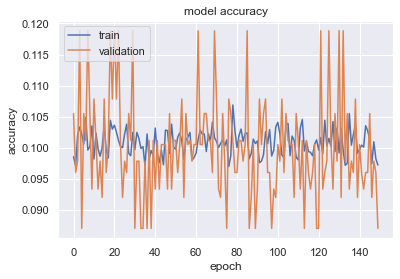

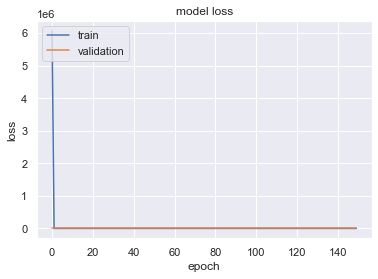

Model # 1


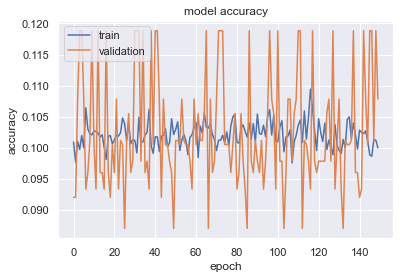

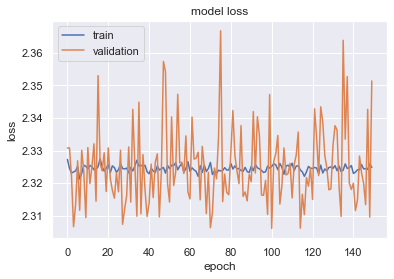

Model # 2


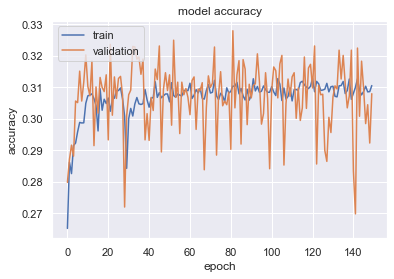

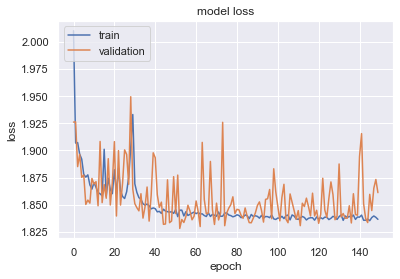

Model # 3


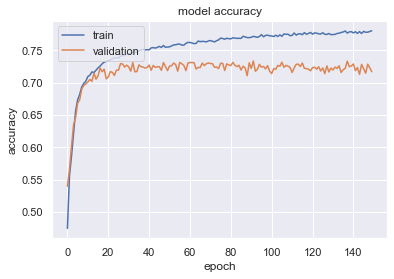

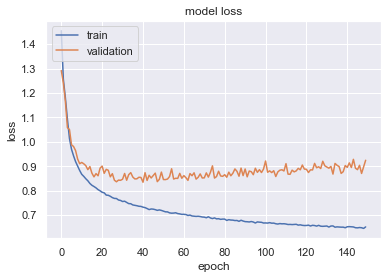

Model # 4


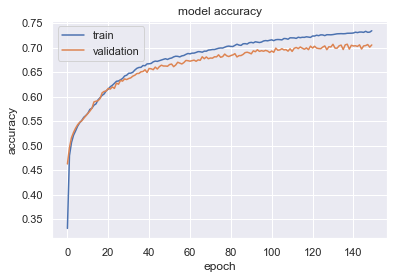

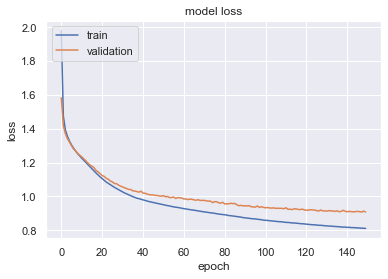

In [13]:
# Print Accuracy (and Val Accuracy) and Loss (and Val Loss) for each model!
count = 0
for history in ensemble.histories:
    print("Model #", count)
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    count += 1